# Tests de Models Unet

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold

# KERAS
from tensorflow.keras import models, layers, utils, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-11-28 06:06:06.484053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 06:06:06.829005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-28 06:06:06.829020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-28 06:06:06.887973: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 06:06:07.947655: W tensorflow/stream_executor/platform/de

In [2]:
#Project Files
from canopywatch.ml_logic.preprocessor import image_preprocessing, image_preprocessing_bulk

## Load images et preprocess

In [3]:
data_path = '../data/Forest Segmented/Forest Segmented/meta_data.csv'
data = pd.read_csv(data_path)

In [4]:
img_path = '../data/Forest Segmented/Forest Segmented/images'
masks_path = '../data/Forest Segmented/Forest Segmented/masks'

In [5]:
# Load and order filenames
image_filepath = sorted([os.path.join(img_path, f) for f in os.listdir(img_path) if f.endswith('.jpg')])
mask_filepath = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.jpg')])

In [6]:
# Faire le image_preprocessing sur toutes les images: (Potentiellement pb de RAM)
# images_processed = image_preprocessing_bulk(image_filepath)
images_processed = []

for i in range(0,1301):
    image_preprocessed = image_preprocessing(image_filepath[i])
    images_processed.append(image_preprocessed)


In [7]:
#1000 masks
masks_pr = []

for i in range(0,1301):
    image_preprocessed = image_preprocessing(mask_filepath[i])
    masks_pr.append(image_preprocessed)


In [8]:
X = images_processed
y = masks_pr

In [9]:
X = np.stack(X)
y = np.stack(y)

In [10]:
y = y[:,:,:,2:]

#### Essai tensorflow load

In [11]:
train_ds = utils.image_dataset_from_directory('../data/Forest Segmented/Forest Segmented/', labels='inferred')

Found 10216 files belonging to 2 classes.


2024-11-28 06:06:14.674049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-11-28 06:06:14.674468: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-28 06:06:14.674489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blackteukbeu-NUC10i7FNK): /proc/driver/nvidia/version does not exist
2024-11-28 06:06:14.676940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class_names = train_ds.class_names
print(class_names)
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['images', 'masks']
(32, 256, 256, 3)
(32,)


In [13]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [14]:
# len(normalized_ds)

#### Verif visuelle de 10 random images


In [15]:
# #Verif visuelle de 10 random images
# fig = plt.figure(figsize=(10, 10))
# count  = 0
# for i in np.random.randint(200, size=10):
#     # Display image
#     image_filename = data.iloc[i]['image']
#     mask_filename = data.iloc[i]['mask']

#     plt.subplot(10, 2, 2*count + 1)
#     # img = image_preprocessing(f'{img_path}/{image_filename}')
#     plt.imshow(images_processed[i])
#     plt.title(image_filename)
#     plt.xticks(())
#     plt.yticks(())

#     # Display corresponding mask
#     plt.subplot(10, 2, 2*count + 2)
#     mask = image_preprocessing(f'{masks_path}/{mask_filename}')
#     plt.imshow(masks_pr[i])
#     plt.title(mask_filename)
#     plt.xticks(())
#     plt.yticks(())
#     count+=1


# plt.tight_layout()
# plt.show()

## Debut des Tests

In [16]:
#Split our data for tests 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building Unet functions : 

In [17]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [18]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [19]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

### Assembler l'Unet et faire le compiler : 

In [20]:
def build_unet_model():
    inputs = layers.Input((256,256,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = Model([inputs], [outputs], name="U-Net")
    return unet_model

In [21]:
def build_unet_model():
    inputs = layers.Input((256,256,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 8)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 16)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 32)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 64)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 16)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 8)
    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = Model([inputs], [outputs], name="U-Net")
    return unet_model

In [22]:
optimizer = Adam()


In [23]:
def model_compile(model):
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics="accuracy")
    return model

In [24]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

In [25]:
unet_model_compiled = model_compile(unet_model)

### Fit the model :

In [26]:
es = EarlyStopping(patience=3, restore_best_weights = True)

history = unet_model_compiled.fit(X_train, y_train, epochs=15, callbacks = [es])

2024-11-28 06:06:16.550025: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 817889280 exceeds 10% of free system memory.


Epoch 1/15
33/33 [==============================] - 406s 12s/step - loss: 1.8806 - accuracy: 0.5287
Epoch 2/15
33/33 [==============================] - 401s 12s/step - loss: 0.6810 - accuracy: 0.6084
Epoch 3/15
33/33 [==============================] - 400s 12s/step - loss: 0.6639 - accuracy: 0.6182
Epoch 4/15
33/33 [==============================] - 399s 12s/step - loss: 0.6410 - accuracy: 0.6550
Epoch 5/15
33/33 [==============================] - 399s 12s/step - loss: 0.6185 - accuracy: 0.6664
Epoch 6/15
33/33 [==============================] - 399s 12s/step - loss: 0.5979 - accuracy: 0.6855
Epoch 7/15
33/33 [==============================] - 399s 12s/step - loss: 0.5849 - accuracy: 0.6996
Epoch 8/15
33/33 [==============================] - 395s 12s/step - loss: 0.5679 - accuracy: 0.7165
Epoch 9/15
33/33 [==============================] - 394s 12s/step - loss: 0.5558 - accuracy: 0.7309
Epoch 10/15
33/33 [==============================] - 393s 12s/step - loss: 0.5563 - accuracy: 0.7245

In [34]:
# Features File Generator

## Extract model Weights
weights = unet_model_compiled.get_weights()

In [35]:
## Print Weights
from tabulate import tabulate

headers = ["N°", "Weight Shape", "Type of Data"]

table = []

for i, weight in enumerate(weights):
    table.append([
        i,
        str(weight.shape),
        str(weight.dtype)
    ])

print(tabulate(table, headers, tablefmt='mixed_outline'))

┍━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   N° │ Weight Shape       │ Type of Data   │
┝━━━━━━┿━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│    0 │ (3, 3, 3, 8)       │ float32        │
│    1 │ (8,)               │ float32        │
│    2 │ (3, 3, 8, 8)       │ float32        │
│    3 │ (8,)               │ float32        │
│    4 │ (3, 3, 8, 16)      │ float32        │
│    5 │ (16,)              │ float32        │
│    6 │ (3, 3, 16, 16)     │ float32        │
│    7 │ (16,)              │ float32        │
│    8 │ (3, 3, 16, 32)     │ float32        │
│    9 │ (32,)              │ float32        │
│   10 │ (3, 3, 32, 32)     │ float32        │
│   11 │ (32,)              │ float32        │
│   12 │ (3, 3, 32, 64)     │ float32        │
│   13 │ (64,)              │ float32        │
│   14 │ (3, 3, 64, 64)     │ float32        │
│   15 │ (64,)              │ float32        │
│   16 │ (3, 3, 64, 1024)   │ float32        │
│   17 │ (1024,)            │ float32        │
│   18 │ (3, 

In [36]:
weights

[array([[[[-0.18101023,  0.33169594,  0.36921376,  0.25448877,
           -0.40323895, -0.3925395 , -0.39876378,  0.15054856],
          [ 0.14165954, -0.4429006 ,  0.06263915, -0.17063896,
            0.02957078, -0.25522697,  0.47425807, -0.130083  ],
          [-0.42125687,  0.32706484,  0.23548609,  0.22135264,
           -0.10489846,  0.09237598, -0.02933002,  0.15083864]],
 
         [[-0.04526908,  0.27599388, -0.4051381 , -0.57300866,
            0.11042262,  0.362082  , -0.35824952,  0.13696209],
          [-0.12206787, -0.10539123, -0.24669644, -0.02553557,
           -0.29989877, -0.59735733, -0.16178311,  0.436992  ],
          [-0.07936369,  0.28262466, -0.52447003, -0.10915925,
           -0.18089604, -0.05041954,  0.06779326, -0.12647533]],
 
         [[ 0.08357678, -0.37713298,  0.55693966,  0.1025942 ,
            0.16327442,  0.3236576 , -0.05021688,  0.500132  ],
          [-0.40591615,  0.6029864 , -0.35498786, -0.0985385 ,
           -0.10605521,  0.19174078, -0.07

In [37]:
len(X_train)

1040

In [38]:
jeanmich = np.expand_dims(X_test[11],axis=0)

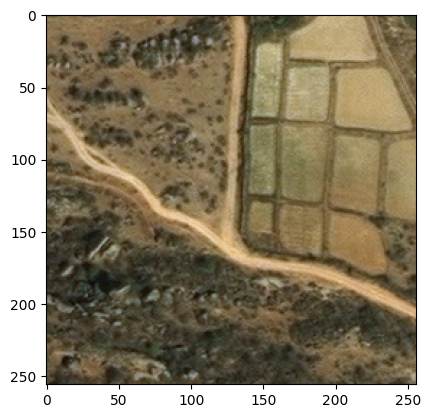

In [39]:
plt.imshow(jeanmich[0])

1/1 [==============================] - 0s 369ms/step


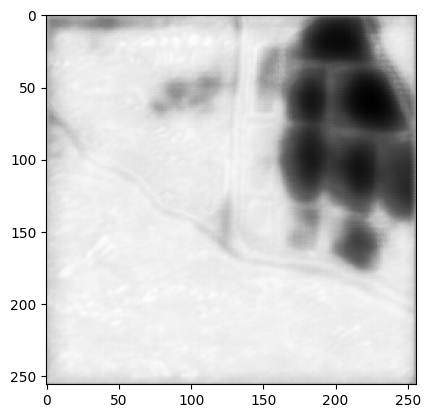

In [33]:
plt.imshow(unet_model_compiled.predict(jeanmich)[0], cmap='gray')